In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
# from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

from torchvision.models import resnet50
from tqdm.notebook import tqdm
# import io
# import zipfile
# from google.oauth2 import service_account
# from googleapiclient.discovery import build
# from googleapiclient.http import MediaIoBaseDownload

#Import my functions
import nbimporter
from Functions import MyDataset, download_dataset, train, validate, plot_loss_accuracy


%matplotlib inline

In [2]:
dtypes = {str(i): 'float64' for i in range(5000)}
dtypes.update({
    'Segment_Time': 'str',
    'lab_flag': 'int',
    'Gender': 'str',
    'Age': 'float64',
})


In [3]:
repo_location = 'D:/simedy' # Change this to the location of the repository on your machine

test = 'Hematocrit'
panel = 'CBC'
time = '15 min'
gender_age_used = "No_GA"
file_path = os.path.join(repo_location, f'CSVs/Vital_{test}_{time}.csv')

#if path does not exist, download the dataset
if not os.path.exists(file_path):
    download_dataset(repo_location)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
num_epochs = 50
batch_size = 128

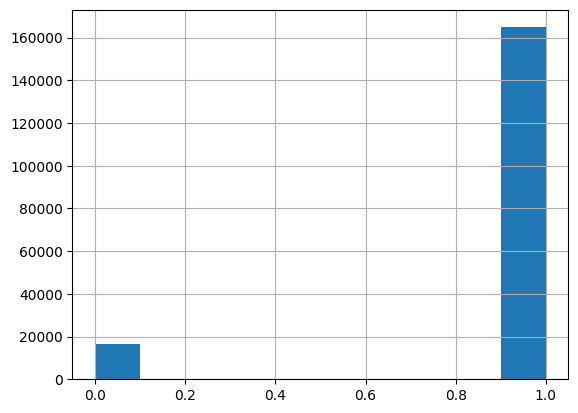

In [6]:
df = pd.read_csv(file_path, dtype=dtypes)
if gender_age_used == "No_GA":
    df = df.drop(columns=['Gender', 'Age'])
if 'SubjectID' in df.columns:
    df = df.drop(columns=['SubjectID'])
df.lab_flag.hist();

In [7]:
#Downsample the class with the majority of data
df_majority = df[df.lab_flag == df.lab_flag.value_counts().index[0]]  
df_minority = df[df.lab_flag == df.lab_flag.value_counts().index[1]]

# If the majority class is at least 5 times the size of the minority class
if len(df_majority) / len(df_minority) >= 5:
    # Downsample majority class
    df_majority_downsampled = df_majority.sample(n=int(len(df_minority)*5), random_state=42)

    # Combine minority class with downsampled majority class
    df = pd.concat([df_majority_downsampled, df_minority])
    print(f"Resampled dataset shape: {df.lab_flag.value_counts()}")

Resampled dataset shape: lab_flag
1    83305
0    16661
Name: count, dtype: int64


In [8]:
#Create a results folder
if not os.path.exists(os.path.join(repo_location, "Notebooks/", panel, "results")):
    os.makedirs(os.path.join(repo_location, "Notebooks/", panel, "results")) 
#Create a plots folder
if not os.path.exists(os.path.join(repo_location, "Notebooks/", panel, "plots")):
    os.makedirs(os.path.join(repo_location, "Notebooks/", panel, "plots"))

In [9]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.resnet = resnet50(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.resnet.fc(x)
        x = F.softmax(x, dim=1)

        return x
    

class ResNet50_age_gender(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50_age_gender, self).__init__()
        self.resnet = resnet50(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Identity()  # Remove the original fully connected layer
        self.dropout = nn.Dropout(p=0.2, inplace=False)
        self.fc = nn.Linear(2048 + 2, num_classes)  # 2048 for ResNet50 features + 2 for age and gender

    def forward(self, x_img, age, gender):
        # Process image data through ResNet50
        x = self.resnet.conv1(x_img)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)

        # Combine image features with age and gender
        age_gender = torch.cat((age.unsqueeze(1), gender.unsqueeze(1)), dim=1)  # Shape: (batch_size, 2)
        combined = torch.cat((x, age_gender), dim=1)  # Shape: (batch_size, 2048 + 2)

        # Pass combined features through the final classification layer
        output = self.fc(combined)
        output = F.softmax(output, dim=1)

        return output

In [10]:
class_counts = df.lab_flag.value_counts().to_numpy()
total_samples = class_counts.sum()
class_weights = total_samples / (class_counts.shape[0] * class_counts)

#If the imbalance between classes is not too high, initialize weights randomly
if class_weights.max()/class_weights.min() <= 2:
    criterion = nn.CrossEntropyLoss()
    
#Otherwise, initialize weights with the class weights
else:
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    if df.lab_flag.value_counts().index[0] == 1:
        class_weights_tensor = class_weights_tensor.flip(0)
    criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
    print(df.lab_flag.value_counts())
    print(class_weights_tensor)

lab_flag
1    83305
0    16661
Name: count, dtype: int64
tensor([3.0000, 0.6000], device='cuda:0')


In [11]:
# Assuming `dataset` is your PyTorch dataset
# dataset = YourDatasetClass()
dataset = MyDataset(df)

# Step 1: Split the dataset indices
dataset_size = len(dataset)
indices = list(range(dataset_size))

# First split: train and temporary (which will be further split into validation and test)
train_indices, temp_indices = train_test_split(indices, test_size=0.4, random_state=42)

# Second split: validation and test (split the temporary set into validation and test)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Step 2: Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Step 3: Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
if gender_age_used == "No_GA":
    model = ResNet50(num_classes = 2)
else:
    model = ResNet50_age_gender(num_classes = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
best_val_acc = 0
train_loss, train_acc, val_loss, val_acc = [], [], [], []
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

  0%|          | 0/50 [00:00<?, ?it/s]

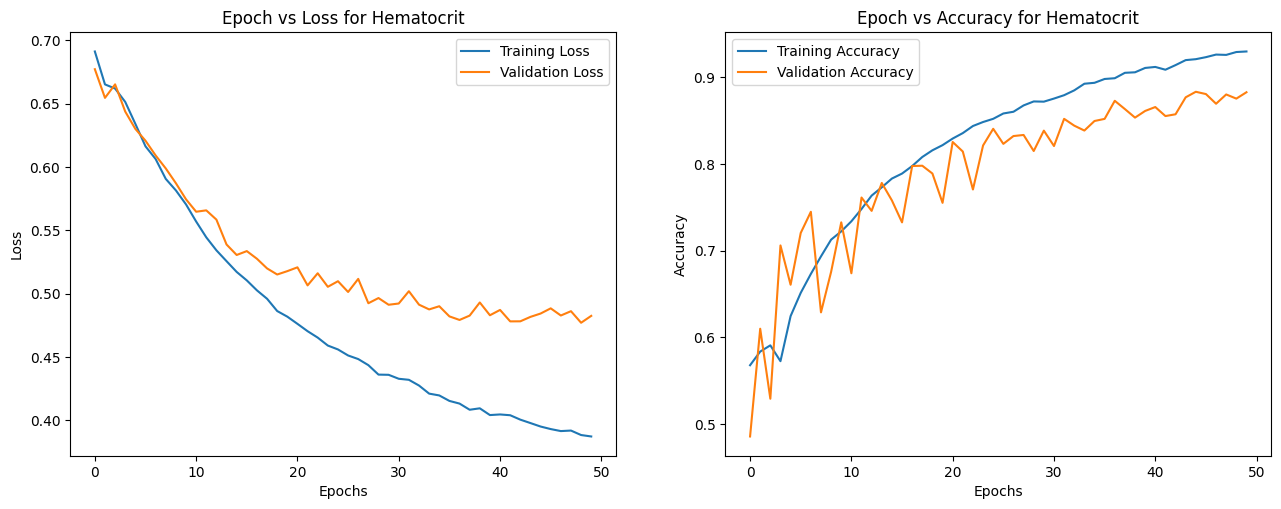

In [13]:
results_df = pd.DataFrame()
best_val_acc = 0
with tqdm(total=num_epochs) as pbar:    
    for epoch in range(1, int(num_epochs + 1)):
        
        train_loss, train_acc = train(model, train_loader, optimizer, criterion,
        epoch, device, gender_age_used, scheduler=scheduler)
        
        val_loss, val_acc, best_val_acc = validate(model, val_loader,
        criterion, best_val_acc, device, test, repo_location, gender_age_used)

        results_dict = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }

        pbar.set_description(f"{test} Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc*100:.2f} - Val Loss: {val_loss:.2f} - Val Acc: {val_acc*100:.2f}")
        results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
        pbar.update(1)

plot_loss_accuracy(results_df.train_loss, results_df.train_acc, results_df.val_loss, results_df.val_acc, test, gender_age_used)
results_df.to_csv(os.path.join(repo_location, f"results/{test}_{gender_age_used}.csv"), index=False)

In [16]:
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision
#if csv results file does not exist, create one
if not os.path.exists(os.path.join(repo_location, "Notebooks", panel, f"results/{panel}_test_results.csv")):
    test_results = pd.DataFrame()
else:
    test_results = pd.read_csv(os.path.join(repo_location, "Notebooks", panel, f"results/{panel}_test_results.csv"))

#Load the best model
if gender_age_used == "No_GA":
    model = ResNet50(num_classes = 2)
else:
    model = ResNet50_age_gender(num_classes = 2)
model.load_state_dict(torch.load(os.path.join(repo_location, f"models/bestmodel_{test}_{gender_age_used}.pth")))
model.to(device)

model.eval()
#Create a confusion matrix
confusion_matrix = np.zeros((2, 2))
outputs = torch.tensor([]).to(device)
targets = torch.tensor([]).to(device)

#Iterate over the test data
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        if gender_age_used == "GA_used":
            inputs, age, gender, labels = data
            inputs, age, gender, labels = inputs.to(device), age.to(device), gender.to(device), labels.to(device)
            labels = labels.long()  # Convert labels to Long type
            output = model(inputs, age, gender)
        else:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output = model(inputs.unsqueeze(1))
        

        _, predicted = torch.max(output.data, 1)
        outputs = torch.cat((outputs, predicted), 0)
        targets = torch.cat((targets, labels), 0)

        for j in range(len(predicted)):
            confusion_matrix[labels[j], predicted[j]] += 1

#Calculate the accuracy
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)

# Calculate precision and recall for class 1
if np.sum(confusion_matrix[:, 1]) == 0:
    precision = 0
else:
    precision = confusion_matrix[1, 1] / np.sum(confusion_matrix[:, 1])

if np.sum(confusion_matrix[1, :]) == 0:
    recall = 0
else:
    recall = confusion_matrix[1, 1] / np.sum(confusion_matrix[1, :])

# Calculate F1 score for class 1
if precision + recall == 0:
    f1 = 0
else:
    f1 = 2 * (precision * recall) / (precision + recall)

# Calculate specificity and NPV for class 0
if np.sum(confusion_matrix[0, :]) == 0:
    specificity = 0
else:
    specificity = confusion_matrix[0, 0] / np.sum(confusion_matrix[0, :])
if np.sum(confusion_matrix[:, 0]) == 0:
    npv = 0
else:     
    npv = confusion_matrix[0, 0] / np.sum(confusion_matrix[:, 0])

#Calculate auroc and auprc
auroc = BinaryAUROC()
auprc = BinaryAveragePrecision()


#Create a dictionary of the results
results_dict = {
    'test': test,
    'class_0_sample':df[df.lab_flag == 0].shape[0],
    'class_1_sample':df[df.lab_flag == 1].shape[0], 
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'specificity': specificity,
    'npv': npv,
    'auroc': auroc(outputs, targets.type(torch.int64)).item(),
    'auprc': auprc(outputs, targets.type(torch.int64)).item(),
    'interval': f"{int(time.split(' ')[0]) * 2} min",
    'Gender_age_used': gender_age_used,
    'notes': f'''''' 
}

#Append the results to the test_results dataframe
test_results = pd.concat([test_results, pd.DataFrame([results_dict])], ignore_index=True)

#Save the results to a csv file
test_results.to_csv(os.path.join(repo_location, "Notebooks", panel, f"results/{panel}_test_results.csv"), index=False)

In [17]:
results_dict

{'test': 'Hematocrit',
 'class_0_sample': 16661,
 'class_1_sample': 83305,
 'accuracy': 0.8850655196558967,
 'precision': 0.9472405630995391,
 'recall': 0.9128947052467283,
 'f1': 0.9297505502567865,
 'specificity': 0.7461031175059952,
 'npv': 0.6317258883248731,
 'auroc': 0.8294988870620728,
 'auprc': 0.9373027086257935,
 'interval': '30 min',
 'Gender_age_used': 'No_GA',
 'notes': ''}

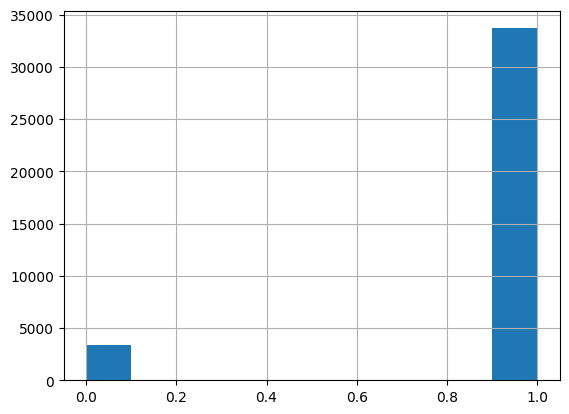

In [15]:
gender_age_used = "GA_used"
df = pd.read_csv(file_path, dtype=dtypes)
if gender_age_used == "No_GA":
    df = df.drop(columns=['Gender', 'Age'])
if 'SubjectID' in df.columns:
    df = df.drop(columns=['SubjectID'])
df.lab_flag.hist();

In [ ]:
#Downsample the class with the majority of data
df_majority = df[df.lab_flag == df.lab_flag.value_counts().index[0]]  
df_minority = df[df.lab_flag == df.lab_flag.value_counts().index[1]]

# If the majority class is at least 5 times the size of the minority class
if len(df_majority) / len(df_minority) >= 5:
    # Downsample majority class
    df_majority_downsampled = df_majority.sample(n=int(len(df_minority)*5), random_state=42)

    # Combine minority class with downsampled majority class
    df = pd.concat([df_majority_downsampled, df_minority])
    print(f"Resampled dataset shape: {df.lab_flag.value_counts()}")

Resampled dataset shape: lab_flag
1    83305
0    16661
Name: count, dtype: int64


In [16]:
class_counts = df.lab_flag.value_counts().to_numpy()
total_samples = class_counts.sum()
class_weights = total_samples / (class_counts.shape[0] * class_counts)
if class_weights.max()/class_weights.min() <= 2:
    criterion = nn.CrossEntropyLoss()
else:
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    if df.lab_flag.value_counts().index[0] == 1:
        class_weights_tensor = class_weights_tensor.flip(0)
    criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
    print(df.lab_flag.value_counts())
    print(class_weights_tensor)

lab_flag
1    33685
0     3419
Name: count, dtype: int64
tensor([5.4261, 0.5507], device='cuda:0')


In [17]:
# Assuming `dataset` is your PyTorch dataset
# dataset = YourDatasetClass()
dataset = MyDataset(df)

# Step 1: Split the dataset indices
dataset_size = len(dataset)
indices = list(range(dataset_size))

# First split: train and temporary (which will be further split into validation and test)
train_indices, temp_indices = train_test_split(indices, test_size=0.4, random_state=42)

# Second split: validation and test (split the temporary set into validation and test)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Step 2: Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Step 3: Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
if gender_age_used == "No_GA":
    model = ResNet50(num_classes = 2)
else:
    model = ResNet50_age_gender(num_classes = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
best_val_acc = 0
train_loss, train_acc, val_loss, val_acc = [], [], [], []
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

  0%|          | 0/50 [00:00<?, ?it/s]

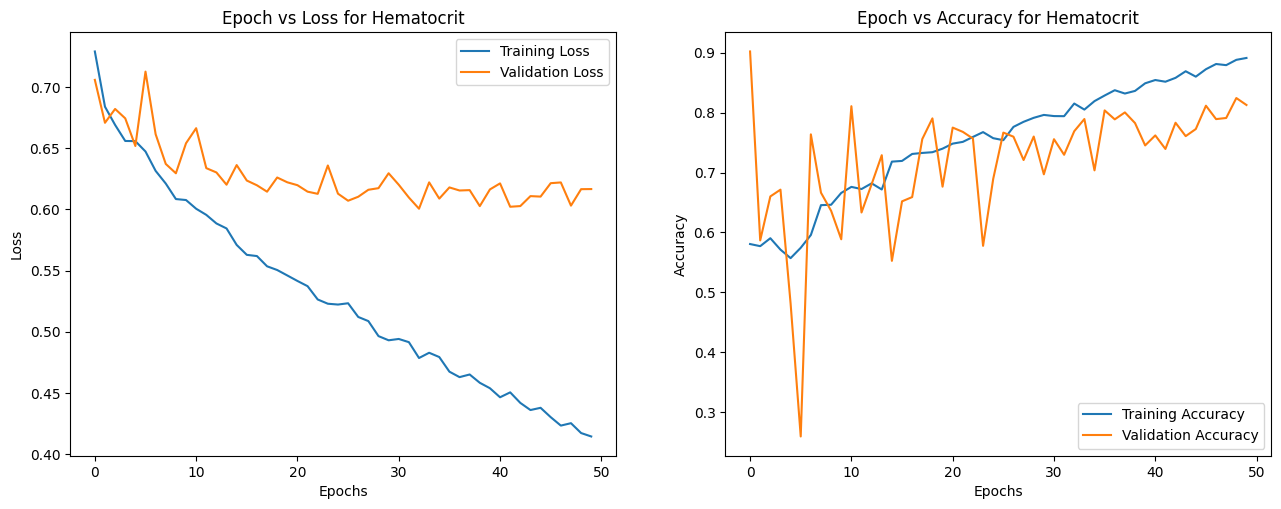

In [19]:
results_df = pd.DataFrame()
best_val_acc = 0
with tqdm(total=num_epochs) as pbar:    
    for epoch in range(1, int(num_epochs + 1)):
        
        train_loss, train_acc = train(model, train_loader, optimizer, criterion,
        epoch, device, gender_age_used, scheduler=scheduler)
        
        val_loss, val_acc, best_val_acc = validate(model, val_loader,
        criterion, best_val_acc, device, test, repo_location, gender_age_used)

        results_dict = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }

        pbar.set_description(f"{test} Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc*100:.2f} - Val Loss: {val_loss:.2f} - Val Acc: {val_acc*100:.2f}")
        results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
        pbar.update(1)

plot_loss_accuracy(results_df.train_loss, results_df.train_acc, results_df.val_loss, results_df.val_acc, test, gender_age_used)
results_df.to_csv(os.path.join(repo_location, f"results/{test}_{gender_age_used}.csv"), index=False)

In [20]:
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision
#if csv results file does not exist, create one
if not os.path.exists(os.path.join(repo_location, "Notebooks", panel, f"results/{panel}_test_results.csv")):
    test_results = pd.DataFrame()
else:
    test_results = pd.read_csv(os.path.join(repo_location, "Notebooks", panel, f"results/{panel}_test_results.csv"))

#Load the best model
if gender_age_used == "No_GA":
    model = ResNet50(num_classes = 2)
else:
    model = ResNet50_age_gender(num_classes = 2)
model.load_state_dict(torch.load(os.path.join(repo_location, f"models/bestmodel_{test}_{gender_age_used}.pth")))
model.to(device)

model.eval()
#Create a confusion matrix
confusion_matrix = np.zeros((2, 2))
outputs = torch.tensor([]).to(device)
targets = torch.tensor([]).to(device)

#Iterate over the test data
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        if gender_age_used == "GA_used":
            inputs, age, gender, labels = data
            inputs, age, gender, labels = inputs.to(device), age.to(device), gender.to(device), labels.to(device)
            labels = labels.long()  # Convert labels to Long type
            output = model(inputs, age, gender)
        else:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output = model(inputs.unsqueeze(1))
        

        _, predicted = torch.max(output.data, 1)
        outputs = torch.cat((outputs, predicted), 0)
        targets = torch.cat((targets, labels), 0)

        for j in range(len(predicted)):
            confusion_matrix[labels[j], predicted[j]] += 1

#Calculate the accuracy
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)

# Calculate precision and recall for class 1
if np.sum(confusion_matrix[:, 1]) == 0:
    precision = 0
else:
    precision = confusion_matrix[1, 1] / np.sum(confusion_matrix[:, 1])

if np.sum(confusion_matrix[1, :]) == 0:
    recall = 0
else:
    recall = confusion_matrix[1, 1] / np.sum(confusion_matrix[1, :])

# Calculate F1 score for class 1
if precision + recall == 0:
    f1 = 0
else:
    f1 = 2 * (precision * recall) / (precision + recall)

# Calculate specificity and NPV for class 0
if np.sum(confusion_matrix[0, :]) == 0:
    specificity = 0
else:
    specificity = confusion_matrix[0, 0] / np.sum(confusion_matrix[0, :])
if np.sum(confusion_matrix[:, 0]) == 0:
    npv = 0
else:     
    npv = confusion_matrix[0, 0] / np.sum(confusion_matrix[:, 0])

#Calculate auroc and auprc
auroc = BinaryAUROC()
auprc = BinaryAveragePrecision()


#Create a dictionary of the results
results_dict = {
    'test': test,
    'class_0_sample':df[df.lab_flag == 0].shape[0],
    'class_1_sample':df[df.lab_flag == 1].shape[0], 
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'specificity': specificity,
    'npv': npv,
    'auroc': auroc(outputs, targets.type(torch.int64)).item(),
    'auprc': auprc(outputs, targets.type(torch.int64)).item(),
    'interval': f"{int(time.split(' ')[0]) * 2} min",
    'Gender_age_used': gender_age_used,
    'notes': f'''''' 
}

#Append the results to the test_results dataframe
test_results = pd.concat([test_results, pd.DataFrame([results_dict])], ignore_index=True)

#Save the results to a csv file
test_results.to_csv(os.path.join(repo_location, "Notebooks", panel, f"results/{panel}_test_results.csv"), index=False)

In [21]:
results_dict

{'test': 'Hematocrit',
 'accuracy': 0.907424875353726,
 'precision': 0.9098404974317383,
 'recall': 0.9970374759294919,
 'f1': 0.9514453318255707,
 'specificity': 0.004477611940298508,
 'npv': 0.13043478260869565,
 'interval': '6 min',
 'Gender_age_used': 'GA_used',
 'class_0_sample': 3419,
 'class_1_sample': 33685,
 'notes': '\n'}

In [22]:
# import shutil
# import os

# def duplicate_file_to_targets(source_file, target_files):
#     """
#     Replaces each target file with the contents of the source file while retaining the target file's name.

#     Args:
#         source_file (str): Path to the source file to duplicate.
#         target_files (list): List of paths to the target files to be replaced.
#     """
#     if not os.path.exists(source_file):
#         print(f"Source file '{source_file}' does not exist.")
#         return

#     for target_file in target_files:
#         try:
#             if os.path.exists(target_file):
#                 os.remove(target_file)  # Remove the existing target file
#             shutil.copy(source_file, target_file)  # Copy the source file to the target location
#             print(f"Copied '{source_file}' to '{target_file}'")
#         except Exception as e:
#             print(f"Failed to copy '{source_file}' to '{target_file}': {e}")

# # Example usage
# source_file = 'Basophils_resnet50.ipynb'  # Path to the source file
# target_files = [
#     r'D:\simedy\Notebooks\CBC\Hematocrit_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\Eosinophils_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\RDW_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\MCHC_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\MCH_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\MCV_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\Monocytes_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\Neutrophils_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\NRBCs_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\Platelets_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\RBCs_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\Lymphocytes_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\WBC_resnet50.ipynb',
#     r'D:\simedy\Notebooks\CBC\Hemoglobin_resnet50.ipynb'
#     # Add more target file paths as needed
# ]

# duplicate_file_to_targets(source_file, target_files)
